# Préliminaire : Installation de bibliothèques

In [17]:
!pip install yfinance
!pip install pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.5 MB/s eta 0:00:00a 0:00:01


# Etape 1 : Importations de fonctions/bilbliothèques et téléchargement des données d'une action (ici Apple)

### Importation de fonctions et bibliothèques utiles

In [128]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from numpy.linalg import LinAlgError
import pandas_datareader.data as web
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
sns.set_style('whitegrid')

### Nous allons étudier l'action Apple

In [129]:
action_nom = 'AAPL'
action_df = yf.download(tickers=action_nom, start='2012-01-01', end='2023-01-29')
action_df.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449693,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516597,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655560,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400


### On récupère la différence du log de l'action lors de la fermeture ajusté
il s'agit du Log du retour d'investisemment d'un jour à l'autre

In [130]:
action_log = np.log(action_df['Adj Close']).diff().dropna()
action_log

Date
2012-01-04    0.005360
2012-01-05    0.011041
2012-01-06    0.010399
2012-01-09   -0.001588
2012-01-10    0.003574
                ...   
2023-01-23    0.023229
2023-01-24    0.010013
2023-01-25   -0.004712
2023-01-26    0.014695
2023-01-27    0.013592
Name: Adj Close, Length: 2785, dtype: float64

# Etape 2 : Plot d'un corrélogramme

### On définit la fonction du correlogramme

In [143]:
def plot_correlogramme(x, lags=None, title=None):
    if lags is None:
        lags = min(10, int(len(x)/5))
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q_stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1,2,3,4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=0.02, y=0.75, s=s, transform=axes[0][1].transAxes)
    u=acf(x)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x=x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('lag')
    axes[1][1].set_xlabel('lag')
    axes[1][0].set_ylim(min(u[1:]-0.05),max(u[1:])+0.05)
    axes[1][1].set_ylim(min(u[1:]-0.05),max(u[1:])+0.05)
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return

### On trace le corrélogramme pour du Log du retour d'investissemennt d'un jour à l'autre

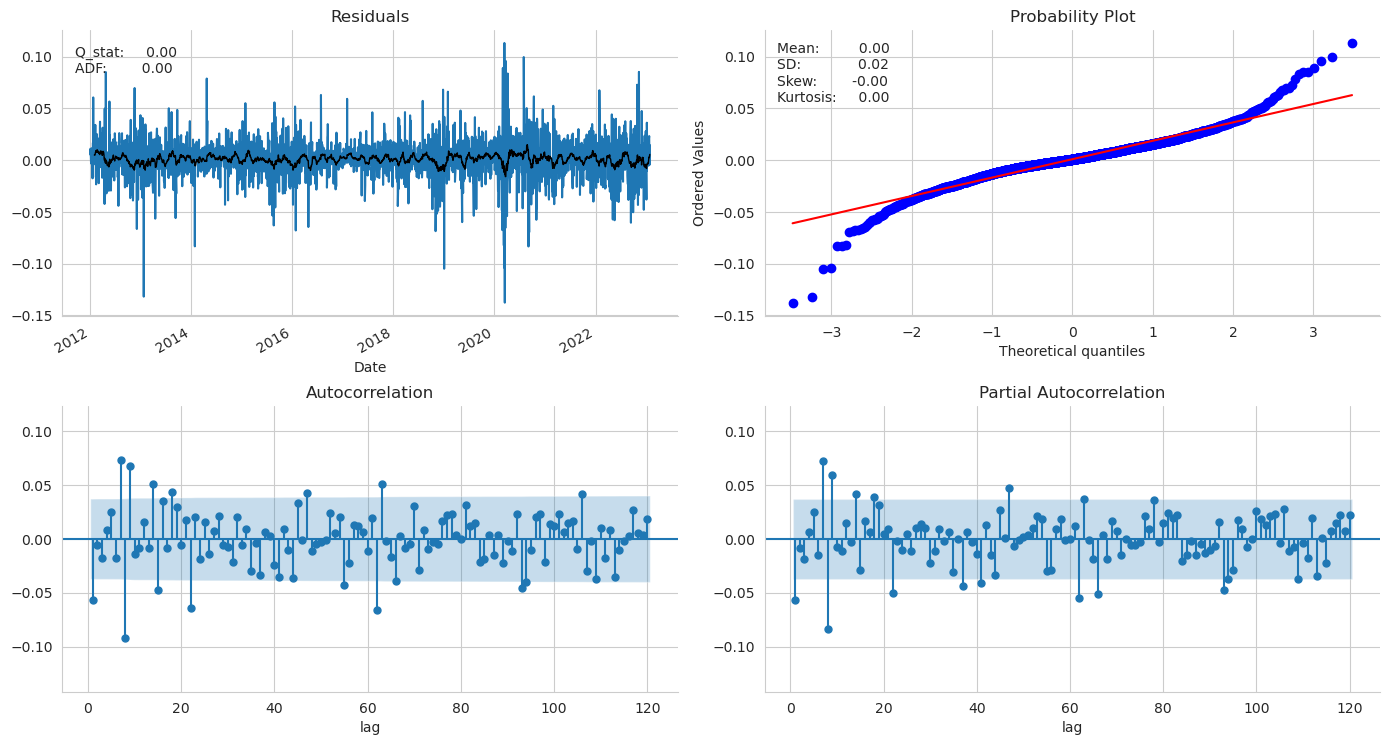

In [144]:
plot_correlogramme(x=action_log,lags=120,title=None)

#### Variation à priori aléatoire

### On trace le corrélogramme de la volatilité journalière

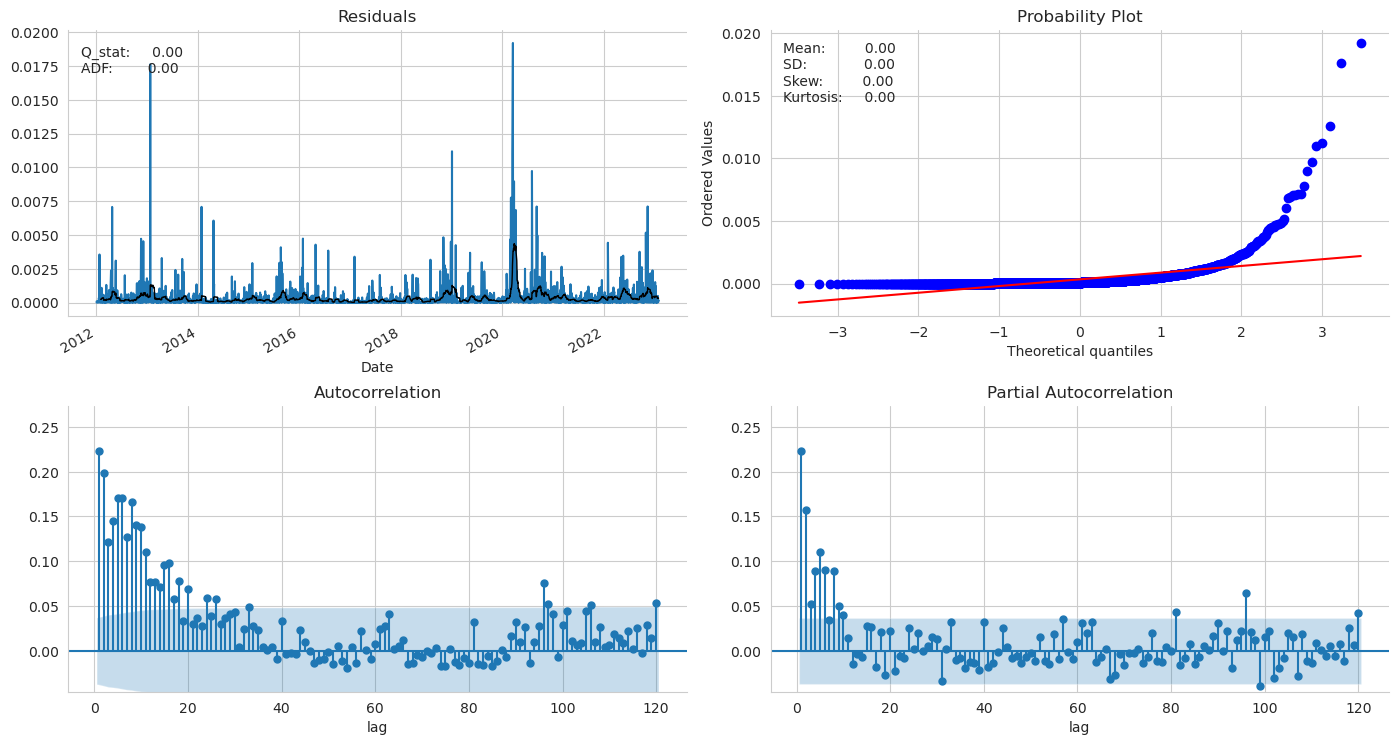

In [145]:
action_vol_j = (action_log - action_log.mean())**2
plot_correlogramme(x=action_vol_j,lags=120,title=None)

#### Contrairement aux variations aléatoire de l'autocorrélation du log du retour d'investissement quotidien, on remarque une décroissance bien dessiné de l'autocorrélation de la volatilité journalière. Ce comportement va nous permettre de prédire selon un modèle GARCH la volatilité des jours futurs

# Etape 3 : Prédication de la volatilité grâce au modèle GARCH